# Simulation

The model fitted in Ott et al.'s paper has a few additional regressors beyond the decision values, to account for specific trials in which participants might have some bias. Importantly, while departure from optimal behaviour in such trials might reflect bias, it might reflect abstraction of states found in these "special cases". If the brain performs state abstraction and that these "special cases" trials have a similar transition probability and reward, they may become lumped together into a state class in participants's representation in the task. If this is the case, then we would expect participants to exhibit consistent behaviour in these trials (where optimal behaviour would predict different behaviour in different trials). Therefore, as a starting point, we will model the data using only 1 parameter associated with the decision value, to avoid shadowing the effect we are after by creating redundant regressors. 

We will use the following model

$$p(accept) = \frac{1}{1+e^{-\eta}}$$

Where

$$\eta = \beta DV $$

The first step in setting up our analysis pipeline is ensuring that our model can accurately retrieve the parameters of interest in the data. To that end, we will simulate data with known ground truth effects, fit our models and make sure that the parameters can be retrieve from the data. We will start with the simplest possible case: simulating data according to the decision values associated with dynamic programming (i.e. optimal policy).

We simulate the data as follows:

$$\eta = \beta_0 + \beta DV + \epsilon$$

Where:
- $\beta_0 \sim \mathcal{N}(0, 1)$ across participants
- $\beta_{dv} \sim \mathcal{N}(2, 1)$ across participants
- $\epsilon \sim \mathcal{N}(0, 5)$ for each trial

In [ ]:
import numpy as np
import pandas as pd
from scipy.special import expit
import pymc as pm
import arviz as az
from scipy import stats
# initialize numpy rng seed:
rng = np.random.default_rng(12345)
az.style.use("arviz-doc")

from stabst.utils import abstract2ground_value
from stabst.MarkovDecisionProcess import MDP
from stabst.TaskConfig import LimitedEnergyTask
import matplotlib.pyplot as plt

# Create task of limited energy:
task = LimitedEnergyTask(O=[1, 2, 3, 4], p_offer=[1/4] * 4)
task.build()
# Create full MDP and compute solution:
task_mdp = MDP(task.states, task.tp, task.r, s2i=task.s2i)
_, Q_full = task_mdp.backward_induction()
# Calculate decision values
DVs = Q_full[:, 1] - Q_full[:, 0]
DVs_norm = stats.zscore(DVs)

# Generate random design matrices for simulated subjects:
n_trials = 200
n_subjects = 20
noise_sigma = 5
e_start = 3
design_matrices = task.design_matrix(n_trials, n_subjects)

# Generate simulated data based on the dynamic programming planning:
data = pd.DataFrame()
betas_mu = [-1, 0.1]
betas_var = [1, 0.01]
subs_betas = []
for sub in range(len(design_matrices)):
    sub_design = design_matrices[sub]
    sub_beta_mu = [np.random.normal(betas_mu[i], betas_var[i]) for i in range(len(betas_mu))]
    subs_betas.append(sub_beta_mu)
    for trial_i, trial in sub_design.iterrows():
        # Extract state values:
        # Energy depends on previous actions
        if trial_i == 0:
            e = e_start
        else:
            e = e_next
        o = trial["offer"]
        cc = trial["costs"]
        # For the last trial in the segment:
        if trial.segment < sub_design["segment"].max():
            fc = sub_design[sub_design["segment"] == trial.segment + 1]["costs"].iat[0]
        else:
            fc = np.random.choice(task.C, 1)
        
        # Get the decision value:
        DV = DVs_norm[task.s2i[(int(e), int(o), int(cc), int(fc), int(trial["trial_within_seg"]))]]

        # Determine response:
        y = np.random.binomial(1, expit(sub_beta_mu[0] + sub_beta_mu[1] * DV))
        if y == 1 and e >= cc:
            e_next = e - cc
        elif y == 1 and e < cc:
            e_next = 0
        elif y == 0 and e < task.max_energy:
            e_next = e + 1
        else:
            e_next = 6

        data = pd.concat([data, pd.DataFrame({
            'subject': sub+1,
            'trial': trial_i,
            'DV': DV,
            'y': y
        }, index=[0])])

data = data.reset_index(drop=True)
subject_codes, subject_labels = pd.factorize(data["subject"])

C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_46732\907578740.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  DV = DVs_norm[task.s2i[(int(e), int(o), int(cc), int(fc), int(trial["trial_within_seg"]))]]


Sampling: [beta0_offset, beta1_offset, mu_b0, mu_b1, sigma_b0, sigma_b1, y]


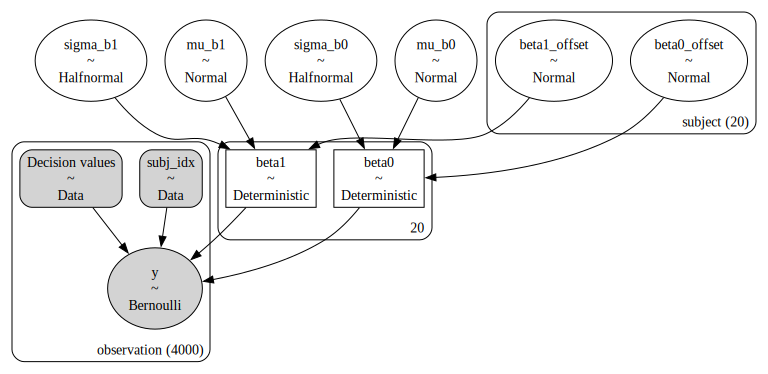

: 

: 

In [ ]:
# Extract the data of one subject:
subj_idx_raw, subj_labels = pd.factorize(data["subject"])
coords = {
    "observation": np.arange(len(data)),
    "subject": subj_labels,
}

with pm.Model(coords=coords) as binomial_regression_model:
    x = pm.Data("Decision values", data["DV"], dims="observation")
    subj_idx = pm.Data("subj_idx", subj_idx_raw, dims="observation")
    # Hyperpriors
    mu_b0 = pm.Normal('mu_b0', mu=0, sigma=2)
    sigma_b0 = pm.HalfNormal('sigma_b0', sigma=2)
    mu_b1 = pm.Normal('mu_b1', mu=0, sigma=2)
    sigma_b1= pm.HalfNormal('sigma_b1', sigma=2)
    # Intercept for each subject, distributed around group mean mu_b0
    b0_offset = pm.Normal('beta0_offset', mu=0, sigma=1, dims="subject")
    b0 = pm.Deterministic("beta0", mu_b0 + b0_offset * sigma_b0)
    # Intercept for each subject, distributed around group mean mu_b1
    b1_offset = pm.Normal('beta1_offset', mu=0, sigma=1, dims="subject")
    b1 = pm.Deterministic("beta1", mu_b1 + b1_offset * sigma_b1)
    # Expected value
    mu = b0[subj_idx] + b1[subj_idx] * x
    pm.Bernoulli("y", logit_p=mu, observed=data["y"], dims="observation")
    # Sample prior:
    idata = pm.sample_prior_predictive(draws=100)

pm.model_to_graphviz(binomial_regression_model)


Before we can fit the model to the simulated data, let's perform prior predictive checks (i.e. simulate data based on the priors we have selected to make sure that they are appropriate):

c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\arviz\plots\hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


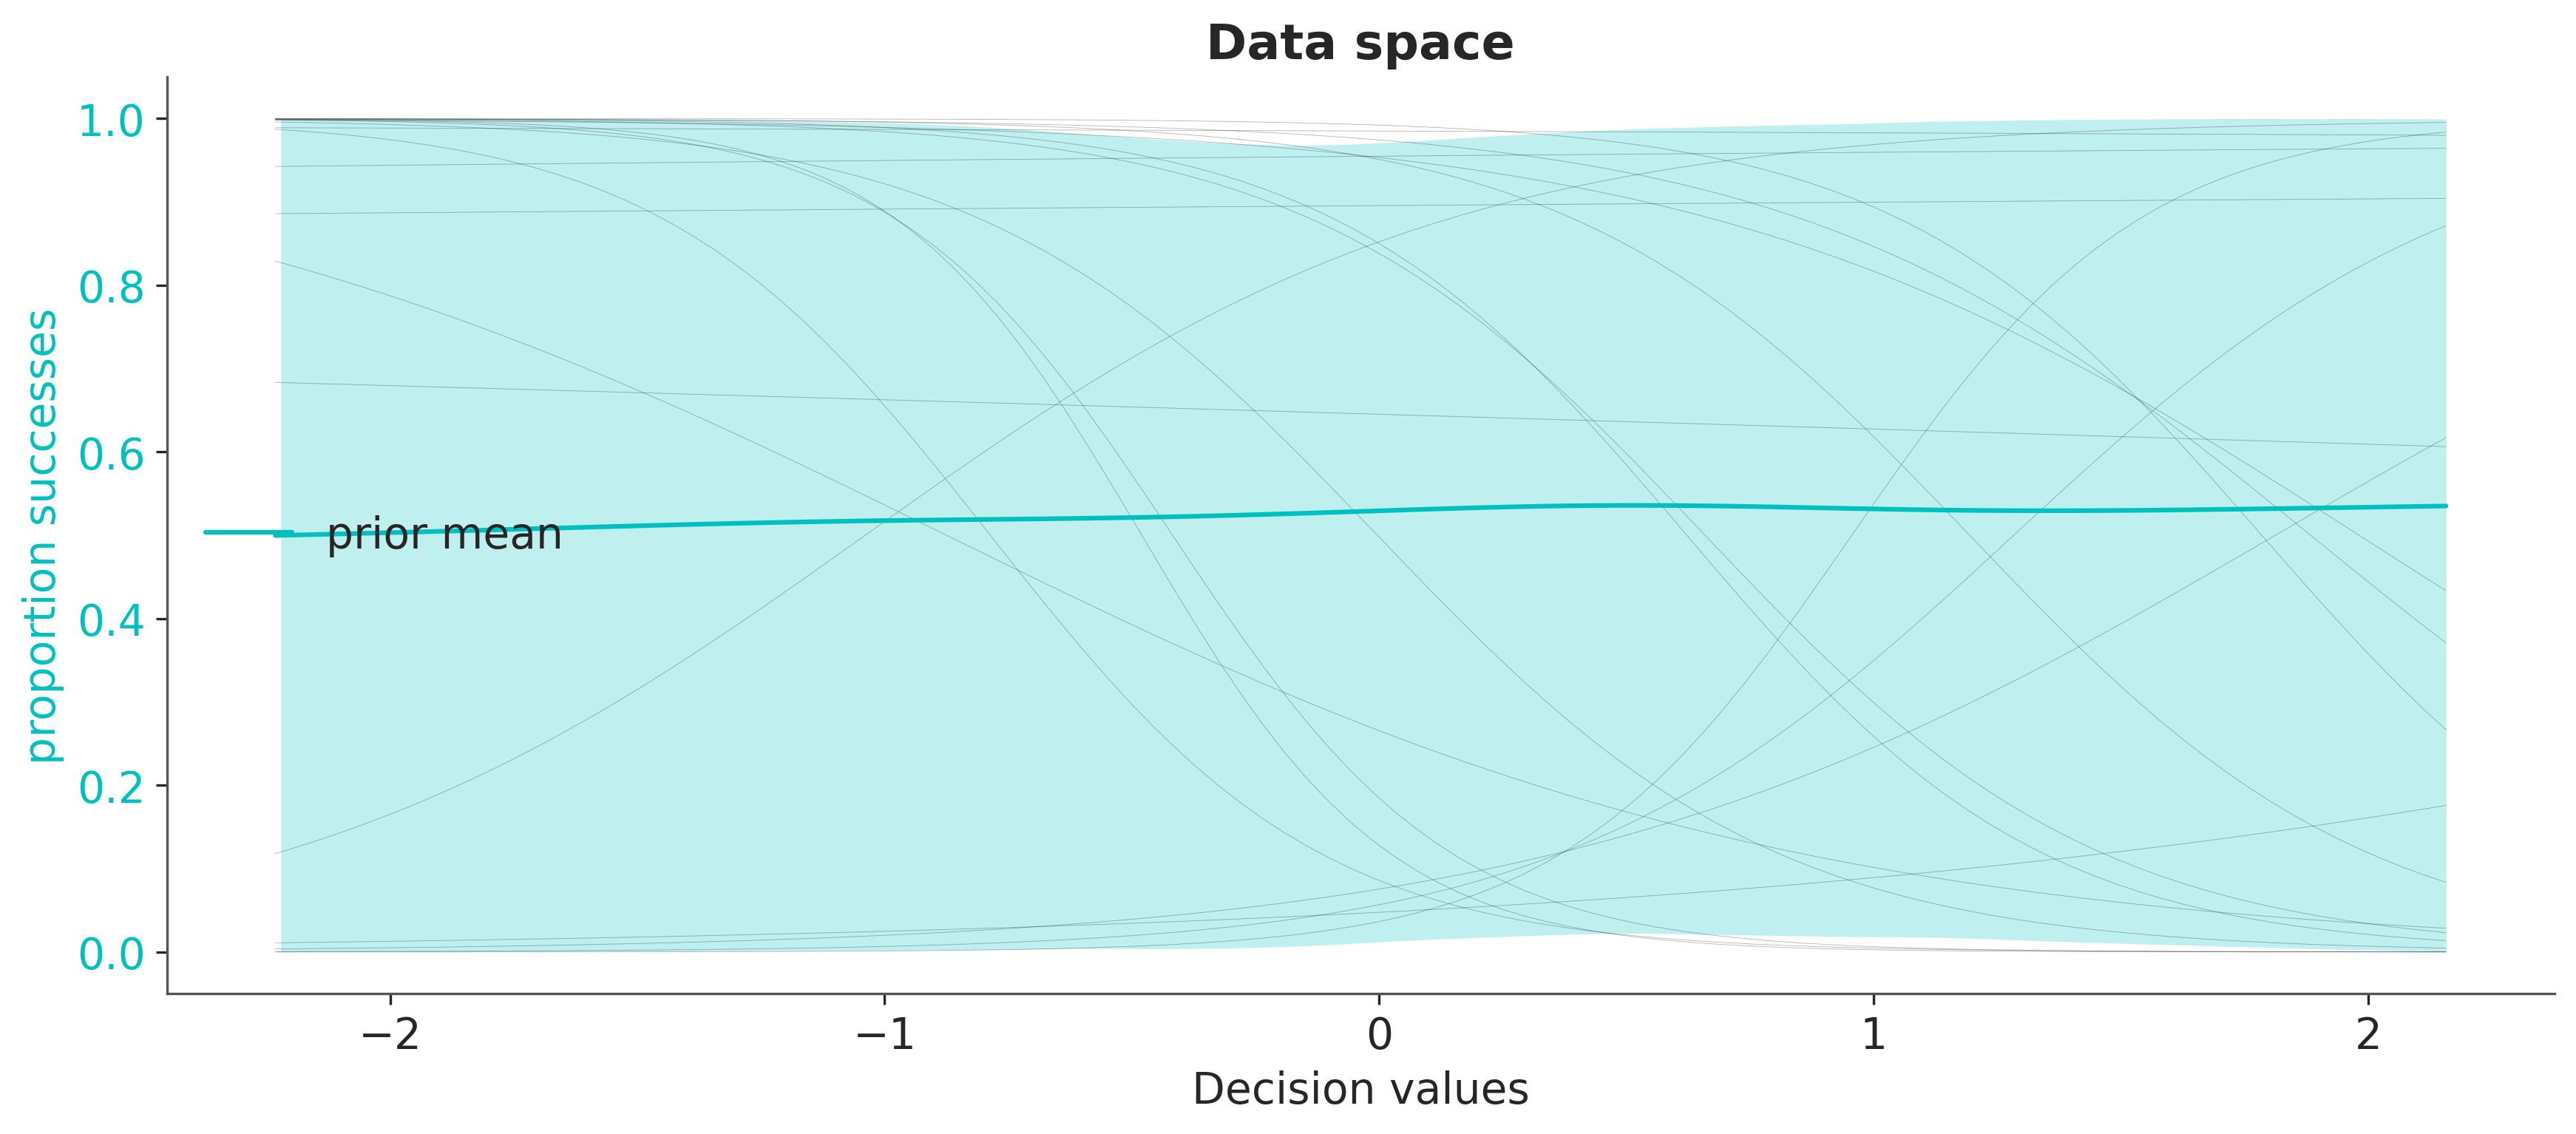

: 

: 

In [ ]:
fig, ax = plt.subplots()
x_grid = np.linspace(data["DV"].min(), data["DV"].max(), 100)
mu_b0 = idata.prior["mu_b0"].stack(sample=("chain", "draw"))  # (sample,)
mu_b1 = idata.prior["mu_b1"].stack(sample=("chain", "draw"))  # (sample,)
sub_b0 = idata.prior["beta0"].stack(sample=("chain", "draw"))  # (sample,)
sub_b1 = idata.prior["beta1"].stack(sample=("chain", "draw"))  # (sample,)

# 3) Compute linear predictor and logistic
eta = mu_b0.values[:, None] + mu_b1.values[:, None] * x_grid[None, :]  # (sample, x)
p = expit(eta)  # probabilities in (0,1)
for i in range(sub_b1.shape[0]):
    ax.plot(x_grid, expit(sub_b0[i, np.random.choice(1, 100)].values + sub_b1[i, np.random.choice(1, 100)].values * x_grid), color='k', linewidth=0.2, alpha=0.3)
az.plot_hdi(x_grid, p,
            hdi_prob=0.95,
            fill_kwargs={"alpha": 0.25, "linewidth": 0},
            ax=ax,
            color="C1",)
ax.plot(x_grid, np.mean(p, axis=0), label="prior mean", color="C1")
ax.set(xlabel="Decision values", title="Data space")
ax.set_ylabel("proportion successes", color="C1")
ax.tick_params(axis="y", labelcolor="C1")
ax.legend()
plt.show()

Now let's fit the data:

c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0_offset, beta1_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 127 seconds.
C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_46732\1292618487.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


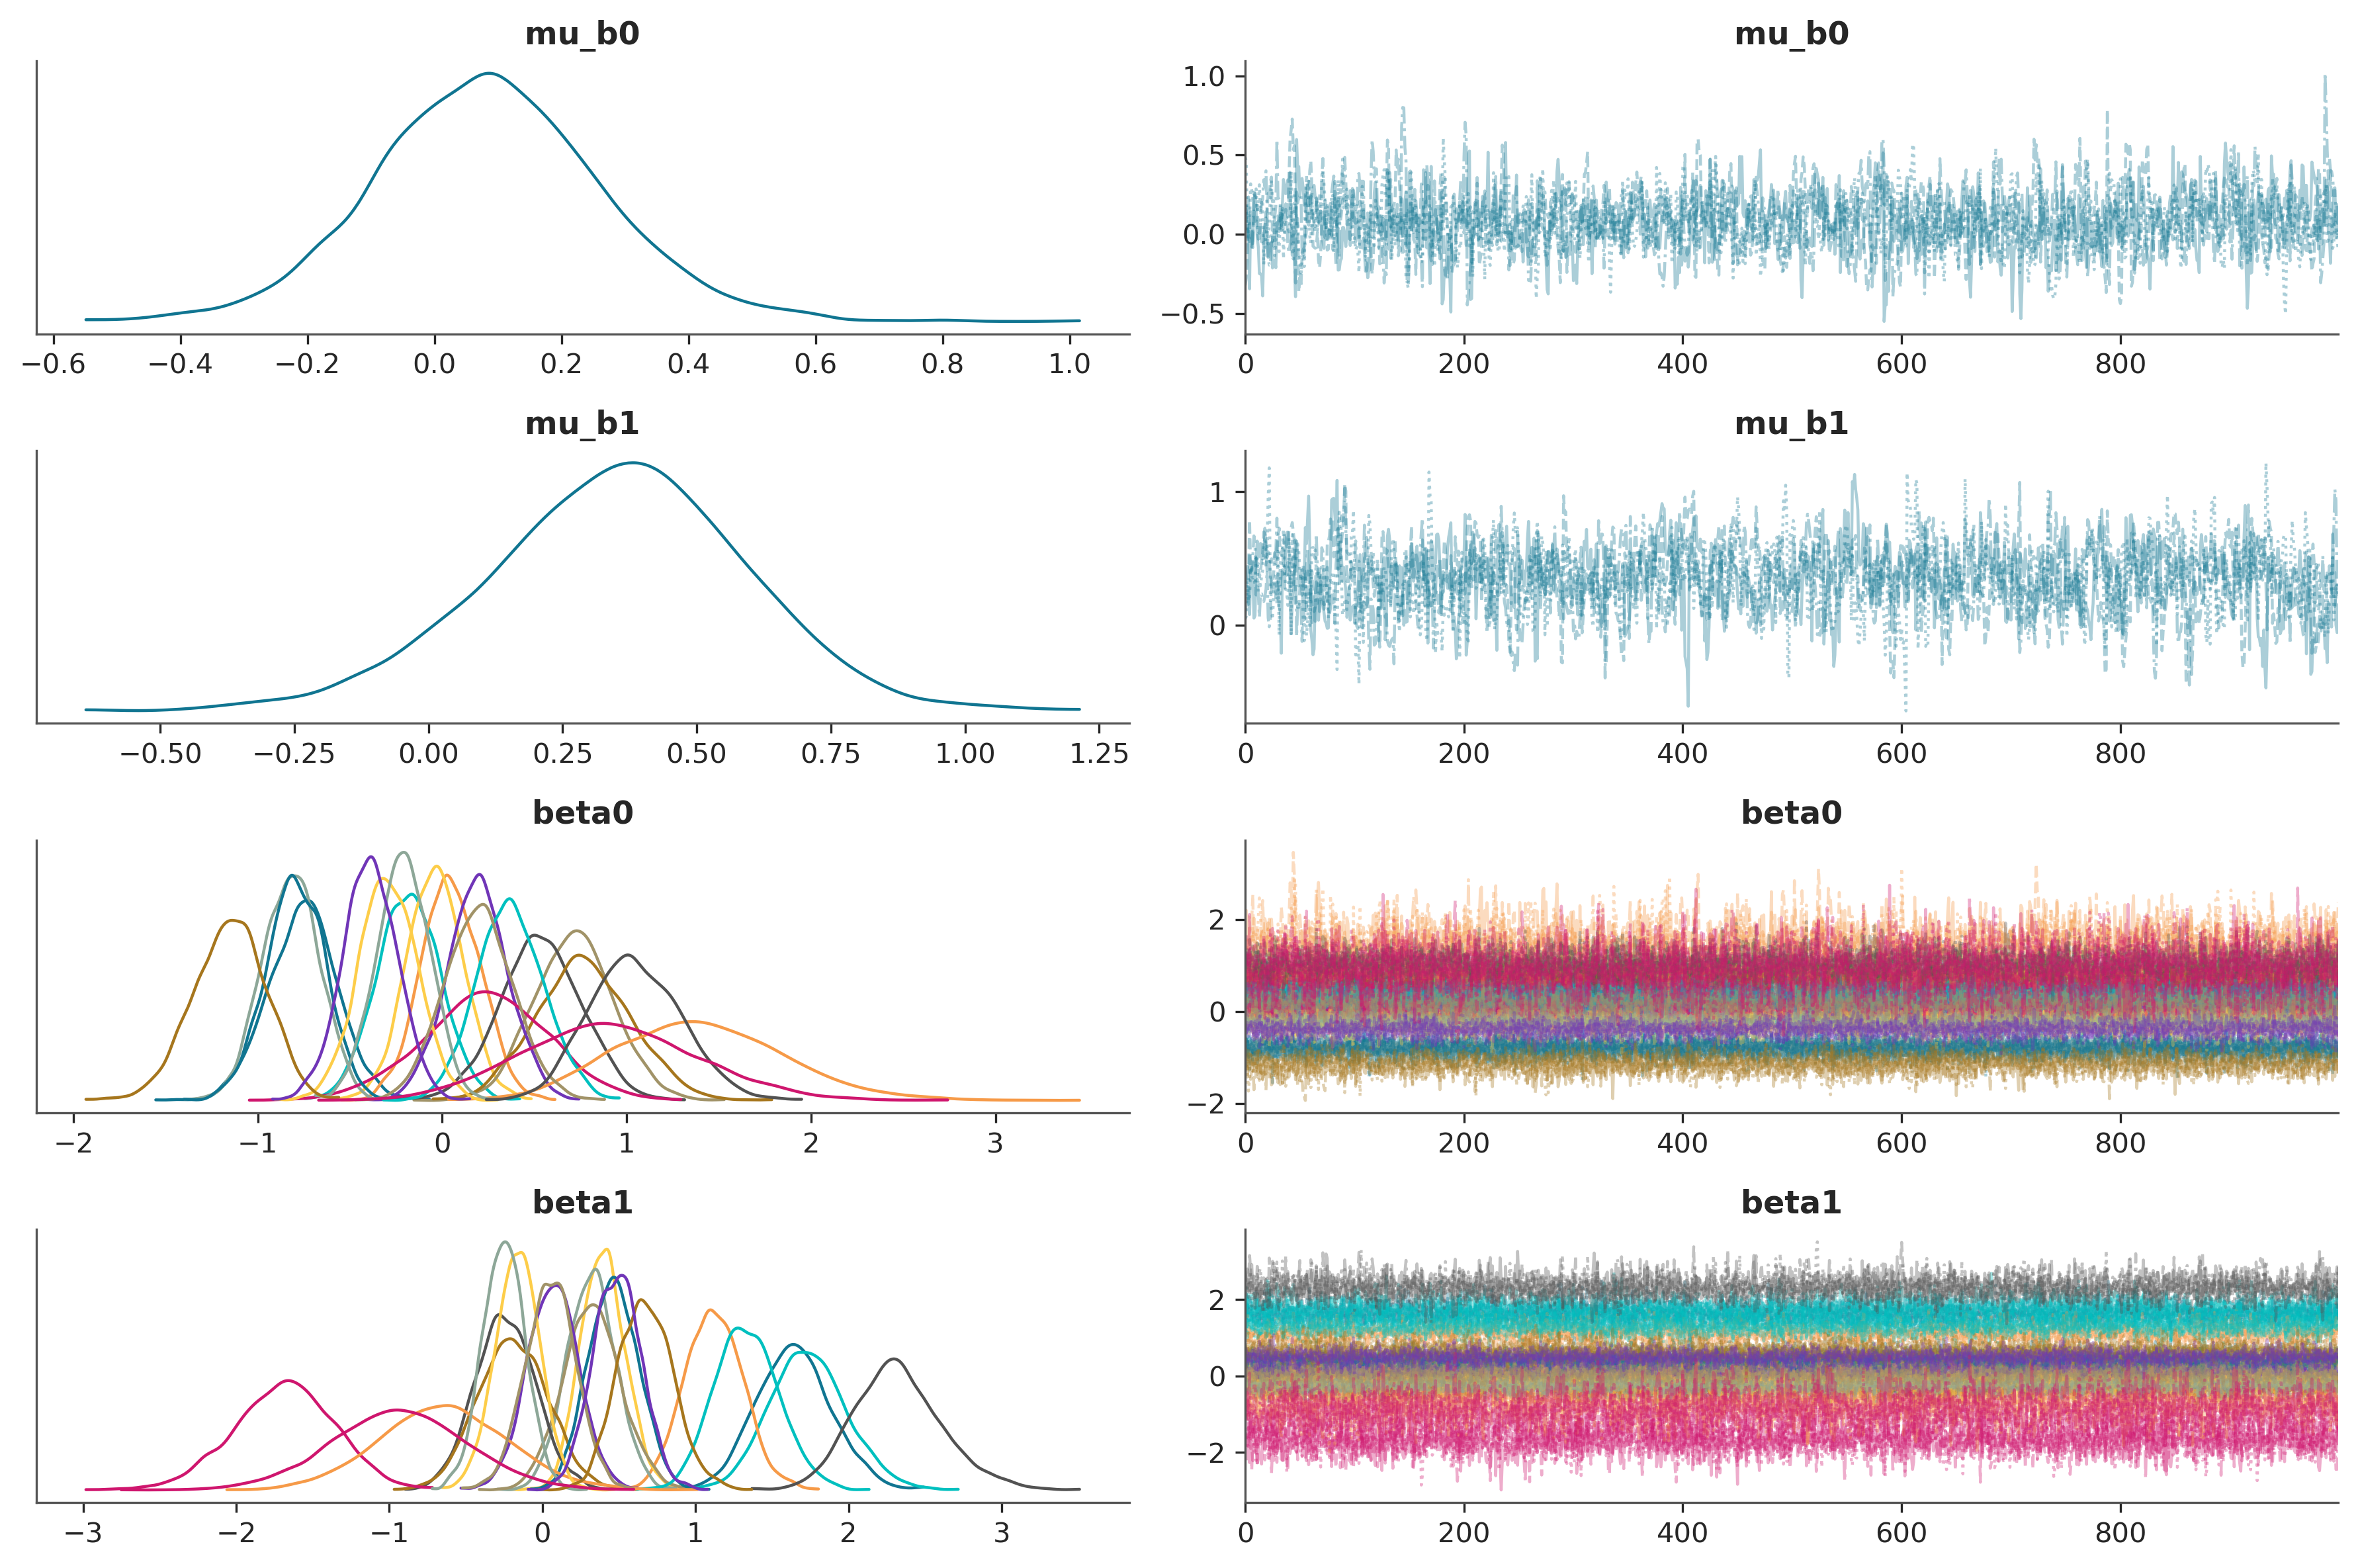

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_b0            0.085  0.180  -0.252    0.426      0.005    0.004    1219.0   
mu_b1            0.350  0.244  -0.133    0.783      0.008    0.006     887.0   
beta0_offset[1] -1.122  0.370  -1.846   -0.459      0.008    0.006    2003.0   
beta0_offset[2] -0.352  0.321  -0.989    0.241      0.007    0.005    2070.0   
beta0_offset[3] -0.046  0.306  -0.574    0.590      0.007    0.005    1897.0   
...                ...    ...     ...      ...        ...      ...       ...   
beta1[15]        0.053  0.165  -0.254    0.365      0.002    0.002    5909.0   
beta1[16]        2.324  0.290   1.782    2.878      0.004    0.004    5055.0   
beta1[17]        0.674  0.180   0.334    0.997      0.002    0.003    5439.0   
beta1[18]        0.490  0.157   0.192    0.772      0.002    0.003    6028.0   
beta1[19]       -0.938  0.442  -1.745   -0.082      0.008    0.008    2793.0   

                 ess_tail  r_hat  
mu_b0              1726.0   1.00  
mu_b1              1211.0   1.01  
beta0_offset[1]    2608.0   1.00  
beta0_offset[2]    2489.0   1.00  
beta0_offset[3]    2854.0   1.00  
...                   ...    ...  
beta1[15]          3388.0   1.00  
beta1[16]          3266.0   1.00  
beta1[17]          2685.0   1.00  
beta1[18]          2815.0   1.00  
beta1[19]          2507.0   1.00  

[84 rows x 9 columns]

: 

: 

In [ ]:
with binomial_regression_model:
    idata = pm.sample(1000, tune=1000)

az.plot_trace(idata, var_names=["mu_b0", "mu_b1", "beta0", "beta1"], combined=True)
plt.tight_layout()
plt.show()
az.summary(idata)

The results highlight that we are well able to retrieve the parameters we have injected in the data: the effect of decision value is close to 2, which is exactly what we have set. Now, let's try to simulate data based on decision values associated with state abstraction representation of the task. 

# Simulating data with state abstraction plan:

The aim of this project is to test whether participants rely on state abstraction to perform complicated tasks. We rely on the bisimulation distance metric from Ferns et al., which yield a distance for each pairs of states. On this basis, we can reduce the size of the MDP at various levels of granularity. Importantly, we don't know whether participants resort to such techniques and if they do, to which level of the granularity they reduce the MDP. Therefore, we need to fit the data using decision values calculated using MDP at various granularity levels and find which level fits the data the best (0 being no state abstraction at all). To do so, we need to make sure that the various DV we have can be dissociated from each other. If we pick abstractions that are not too dissimilar from each other, the resulting DV associated with each will be highly similar and therefore we don't be able to discriminate between them. To determine the kind of differences we can pick up experimentally, we can once again rely on simulated data: we can simulate data using DV obtained from an arbitrary abstraction levels, then fit data using DV from any abstraction level and perform model comparison to see whether we can tell them appart. 

In [ ]:
# Load the distance matrix:
states_dist_mat = np.load('../data/bids/limited_energy/derivatives/state_abstraction/bisimulation_distance_matrix.npy')

# Compute decision values associated with different abstraction levels:
DVs = dict()
sample_eps = np.sort(np.unique(np.round(states_dist_mat, decimals=3)))[0:10]
for eps in sample_eps: #unique_dist:
    # Find states clusters
    abstract_mdp, state_classes, class_of_state = task_mdp.distance_reduce_mdp(eps, distance_matrix=states_dist_mat)
    # Solve the MDP:
    V_R, Q_R = abstract_mdp.backward_induction()
    # Project back to full space:
    V, Q = abstract2ground_value(class_of_state, V_R, Q_R)
    DVs[f'eps: {eps}'] = stats.zscore(Q[:, 1] - Q[:, 0])


: 

: 

In [ ]:
# Simulate data:
# Generate random design matrices for simulated subjects:
n_trials = 200
n_subjects = 20
noise_sigma = 5
e_start = 3
design_matrices = task.design_matrix(n_trials, n_subjects)
sim_dv_eps = np.random.choice(sample_eps, 1)

# Generate simulated data based on the dynamic programming planning:
data = pd.DataFrame()
betas_mu = [0, 2]
betas_var = [1, 1]
decision_noise = 1
subs_betas = []
for sub in range(len(design_matrices)):
    sub_design = design_matrices[sub]
    sub_beta_mu = [np.random.normal(betas_mu[i], betas_var[i]) for i in range(len(betas_mu))]
    subs_betas.append(sub_beta_mu)
    for trial_i, trial in sub_design.iterrows():
        # Extract state values:
        # Energy depends on previous actions
        if trial_i == 0:
            e = e_start
        else:
            e = e_next
        o = trial["offer"]
        cc = trial["costs"]
        # For the last trial in the segment:
        if trial.segment < sub_design["segment"].max():
            fc = sub_design[sub_design["segment"] == trial.segment + 1]["costs"].iat[0]
        else:
            fc = np.random.choice(task.C, 1)
        
        # Get the decision value:
        DV = DVs[f'eps: {sim_dv_eps[0]}'][task.s2i[(int(e), int(o), int(cc), int(fc), int(trial["trial_within_seg"]))]]

        # Determine response:
        y = np.random.binomial(1, expit(sub_beta_mu[0] + sub_beta_mu[1] * DV + np.random.normal(0, decision_noise, size=1)))
        if y == 1 and e >= cc:
            e_next = e - cc
        elif y == 1 and e < cc:
            e_next = 0
        elif y == 0 and e < task.max_energy:
            e_next = e + 1
        else:
            e_next = 6

        data = pd.concat([data, pd.DataFrame({
            'subject': sub+1,
            'trial': trial_i,
            'y': y,
            **{f'DV, eps={eps}': DVs[f'eps: {eps}'][task.s2i[(int(e), int(o), int(cc), int(fc), int(trial["trial_within_seg"]))]] 
               for eps in sample_eps}
        }, index=[0])])

data = data.reset_index(drop=True)
subj_idx_raw, subj_labels = pd.factorize(data["subject"])
coords = {
    "observation": np.arange(len(data)),
    "subject": subj_labels,
}

C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_46732\3596846600.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  DV = DVs[f'eps: {sim_dv_eps[0]}'][task.s2i[(int(e), int(o), int(cc), int(fc), int(trial["trial_within_seg"]))]]
C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_46732\3596846600.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  **{f'DV, eps={eps}': DVs[f'eps: {eps}'][task.s2i[(int(e), int(o), int(cc), int(fc), int(trial["trial_within_seg"]))]]


: 

: 

In [ ]:
# Fit models at all epsilons:
traces = dict()

for eps in sample_eps:
    # Model the data:
    with pm.Model(coords=coords) as binomial_regression_model:
        x = pm.Data("x", data[f'DV, eps={eps}'], dims="observation")
        subj_idx = pm.Data("subj_idx", subj_idx_raw, dims="observation")
        # Hyperpriors
        mu_b0 = pm.Normal('mu_b0', mu=0, sigma=2)
        sigma_b0 = pm.HalfNormal('sigma_b0', sigma=2)
        mu_b1 = pm.Normal('mu_b1', mu=0, sigma=2)
        sigma_b1= pm.HalfNormal('sigma_b1', sigma=2)
        
        # Intercept for each subject, distributed around group mean mu_b0
        b0_offset = pm.Normal('beta0_offset', mu=0, sigma=1, dims="subject")
        b0 = pm.Deterministic("beta0", mu_b0 + b0_offset * sigma_b0)
        # Intercept for each subject, distributed around group mean mu_b1
        b1_offset = pm.Normal('beta1_offset', mu=0, sigma=1, dims="subject")
        b1 = pm.Deterministic("beta1", mu_b1 + b1_offset * sigma_b1)
        
        # Expected value
        mu = b0[subj_idx] + b1[subj_idx] * x
        pm.Bernoulli("y", logit_p=mu, observed=data["y"], dims="observation")

        traces[f'DV, eps={eps}'] = pm.sample(500, tune=500, idata_kwargs={"log_likelihood": True})

# Compare models:
model_comparison = az.compare(traces)

# Plot the results of the model comparison:
az.plot_compare(model_comparison);
print(sim_dv_eps)

c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0_offset, beta1_offset]


KeyboardInterrupt: 

: 

: 

In [ ]:
model_comparison

rank     elpd_loo      p_loo   elpd_diff        weight  \
DV, eps=0.009     0 -2026.355127  35.707364    0.000000  1.000000e+00   
DV, eps=0.008     1 -2101.257448  35.734448   74.902321  1.264031e-07   
DV, eps=0.007     2 -2165.853853  36.017047  139.498726  1.067918e-07   
DV, eps=0.006     3 -2316.263860  37.063333  289.908733  6.192673e-08   
DV, eps=0.005     4 -2376.446677  37.177333  350.091550  4.496750e-08   
DV, eps=0.004     5 -2437.679826  36.351320  411.324700  2.979147e-08   
DV, eps=0.003     6 -2450.751239  38.541798  424.396113  2.943532e-08   
DV, eps=0.001     7 -2567.309108  33.531356  540.953982  3.847472e-09   
DV, eps=0.002     8 -2567.995199  33.624320  541.640072  3.649893e-09   
DV, eps=0.0       9 -2584.071594  33.016521  557.716467  0.000000e+00   

                      se        dse  warning scale  
DV, eps=0.009  30.257772   0.000000    False   log  
DV, eps=0.008  29.806109  12.462997    False   log  
DV, eps=0.007  29.591459  16.071424    False   log  
DV, eps=0.006  26.876125  21.898792    False   log  
DV, eps=0.005  25.726007  23.935852    False   log  
DV, eps=0.004  23.852774  24.902710    False   log  
DV, eps=0.003  23.987887  26.065135    False   log  
DV, eps=0.001  19.773946  26.764983    False   log  
DV, eps=0.002  19.768167  26.764649    False   log  
DV, eps=0.0    19.120932  27.041939    False   log

: 

: 